# 1.1 Searching for $H\rightarrow b\bar{b}$

One of the primary physics objectives of the Large Hadron Collider is to study the Higgs Boson and understand the process with which particles acquire mass. The Higgs Boson's decays channels along with the respective branching ratios are shown in the figure below. 

<img src="https://physicsforme.files.wordpress.com/2012/07/higgs_decay.jpg" width="400" />



In 2012 the Higgs Boson was discovered in the $H\rightarrow\gamma\gamma$ and $H\rightarrow ZZ \rightarrow 4l$. The plot below shows a clear excess of signal events over background around 125 GeV in the $H\rightarrow ZZ \rightarrow 4l$ 'golden channel'. 

<img src="https://3c1703fe8d.site.internapcdn.net/newman/gfx/news/hires/2017/newatlasprec.png" width="400" />


But if the Higgs Boson predominantly decays to a pair of $b$-quarks, why wasn't it discovered in the $H\rightarrow b\bar{b}$ channel? 

The discovery channels leave a clean signature in the detector that is easy to isolate making searches in the $H\rightarrow\gamma\gamma$ or $H\rightarrow ZZ \rightarrow 4l$ favourable. However, $H\rightarrow b\bar{b}$ searches aren't so straightforward!

Here's why:

## Large background 

Firstly, the $H\rightarrow b\bar{b}$ process at the LHC has enourmous amount of background with final states that are the same as the signal i.e. two $b$-quarks. The figure below shows the cross sections (likelihood) of a Higgs event and compared to a bb event at the LHC. In the LHC current operational energy, only around 1 in a trillion proton-proton collisions create a Higgs boson. 


<img src="../docs/images/lhc_cross_sections.png" width="400" />

Hence, the signal can get drowned out in with the signal-like background. 

## Jet Production

Secondly, precisely measuring and distinguishing $b$-quarks from say $c$-quarks is also challenging. When a pair of $b$-quarks is created in the ATLAS detector they go through a process known as hadronisation and form [jets](https://www.youtube.com/watch?v=FMH3T05G\_to). The jets must be identified as originating from b-quarks (b-jets) by a process known as $b$-tagging. This extra level of complexity along with the large background makes searches for $H\rightarrow b\bar{b}$ challenging. 

## 1.2 One - Lepton Channel

The process we will be searching for is shown in the Feynman Diagram below. A Higgs Boson is radiated off a $W^\pm$ boson which subsequently decays to a pair of _b_-quarks. The $W^\pm$ boson then goes on to decay into a lepton and a corresponding neutrino. 

<img src="images/one-lepton.png" width="350" />



The final state products of a 1-lepton channel $H\rightarrow b\bar{b}$ process are:
   * A Neutrino
   * A charged Lepton (e u)
   * 2 _b_-jets


## 1.4 Separating Signal from Background


We separate ATLAS events using *Kinematic* (momentum, energy, mass etc) and Topological parameters (spatial separation between particles). A list of the event variables that we will be using in this exercise is shown below: 



| Variable        | Description           | Label  |
| ------------- |:-------------:| -----:|
|$\Delta R(b_1b_2)$      | Angle between the two *b*-tagged jets | dRBB |
| $p_T^V$      | Missing Transverse Momentum      |   pTV |
| $m_{top}$ | Reconstructed Top Quark Mass      |    Mtop |
| $E^{Miss}_{T}$ | Missing Transverse Energy     |    MET |


                    Table 1: Kinematic and topological paramaeters used to identify events. 



## 2. $H\rightarrow b\bar{b}$ via Sequential Cuts

In this section we are going to be applying a set of selection cuts on the kinematic and topological paramaters to select signal events and reject background events. We will be applying cuts on all variables other than $m_{bb}$ and see what effect the cut has on the $m_{bb}$ distribution histogram. 

To evaluate the cuts we will compare the number of signal and background events in each bin to calculate the _signal sensitivity_. Our goal is to apply cuts that isolate as much of the signal as possible and maximise the _signal sensitivity_. 


# 2.1 Finding Cuts

**In this section we will be using the simulated data to determine what cuts must be applied on the kinematic and topoligical parameters to identify the signal region.**


To do this we will use the plot_variable() function to visualise how a particular kinematic or topological event variable is distributed for the various process involved. We wll use this distribution to determine the appropriate cuts. Let's use an example to illustrate this concept.

The code below plots the distribution of the reconstructed top mass $M_{top}$. The signal (labelled $VH \rightarrow bb$ in the legend) is shown in red on the histogram. For clarity a red solid line has also been plotted to help identify the sigal region. 



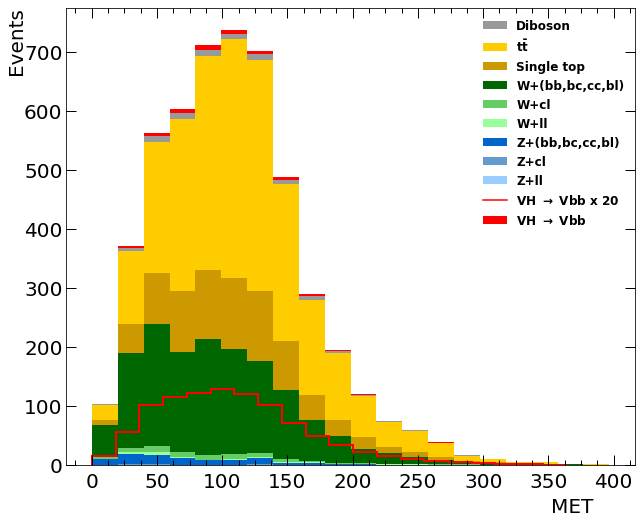

In [69]:
# Importing required libraries
import pandas as pd
import numpy as np
from copy import deepcopy
from ucl_masterclass import *
import matplotlib as mpl

# Loading Data

# The data is loaded into a pandas data frame
df = pd.read_csv('../data-v1/VHbb_data_2jet.csv')
df_original = deepcopy(df)


# The plot_variable takes two arguments. First is the data frame used to plot the distributions and
# second is the variable in question. 

plot_variable(df,'MET')

### Exercise 2.1 Use the plot variable function to plot another variable (like MET) which is the missing transverse energy.

In [3]:
# make your plot here!


### Exercise 2.2 Plot the event variables and determine the cuts that will isolate the signal region. Note these cuts down in your notebook.


An example is shown in the cells below where it was identified that by requiring that Mtop > 225 GeV we eliminate a large amount of the $t\bar{t}$ and single top background. 

By changing the variable plotted determine your own list of cuts. 

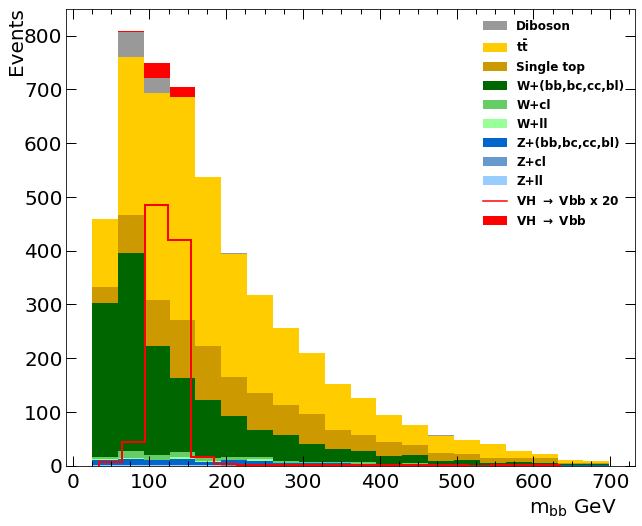

Sensitivity achieved before cuts  1.4315010699504847


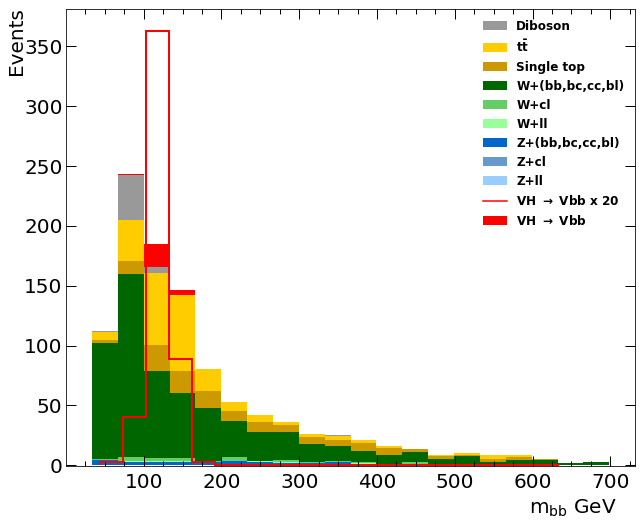

Sensitivity achieved after cuts  1.5840108518283766


In [6]:
# Reload data
df = pd.read_csv('../data-v1/VHbb_data_2jet.csv')

# Apply cut
df = df.loc[df["Mtop"] / 1e3 > 250] # divide by 1e3 to convert from MeV to GeV

# The code below plots the mBB distribution after the cut is applied
plot_variable(df_original,'mBB')
print("Sensitivity achieved before cuts ",sensitivity_cut_based(df_original))

plot_variable(df,'mBB')

print("Sensitivity achieved after cuts ",sensitivity_cut_based(df))

As shown in the above plots of the $m_{bb}$ distribution, once the cut is applied we eliminate a large amount of $t\bar{t}$ background.

### Determine a set of additional cuts that will help isolate the signal. Each time you optimise a new cut value, note down the new sensitivity. After you have optimised all the cuts, plot the sensitivity increase as each new cut is applied. Code to create plots in python is provided below. 


Use the cell below to apply your final cuts sequentially. 



In [ ]:
# Reload data
df = pd.read_csv('../data-v1/VHbb_data_2jet.csv')

# Apply a cut here!
# =================



# The code below plots the mBB distribution after the cut is applied
plot_variable(df_original,'mBB')
print("Sensitivity achieved before cuts ",sensitivity_cut_based(df_original))

plot_variable(df,'mBB')

print("Sensitivity achieved after cuts ",sensitivity_cut_based(df))

In [ ]:
## Plotting sensitivity graph

# Add the sensitivities you noted down to the list
sensitivities = 

# Add variable names to the list below. Make sure you keep the same order
variable_names = 

num_variables_used = len(sensitivities)



fig = plt.figure()
fig.set_size_inches(8.5,7)
x = list(np.arange(0,num_variables_used,1))
plt.plot(x,sensitivities,'o')
plt.xlim(-1,5)
plt.ylim(1,3)
plt.xticks(x, variable_names);

plt.xlabel('Variables')
plt.ylabel('Sensitivity')


# Once you have finalised your plots you can export a .png file by uncommenting the code below
#plt.savefig('cut_based_variable_comparison.png')

### Exercise 2.3 Cutting multiple variables

So far, we have only asked you to cut on 1 variable at a time. Now, we shall cut on two variables



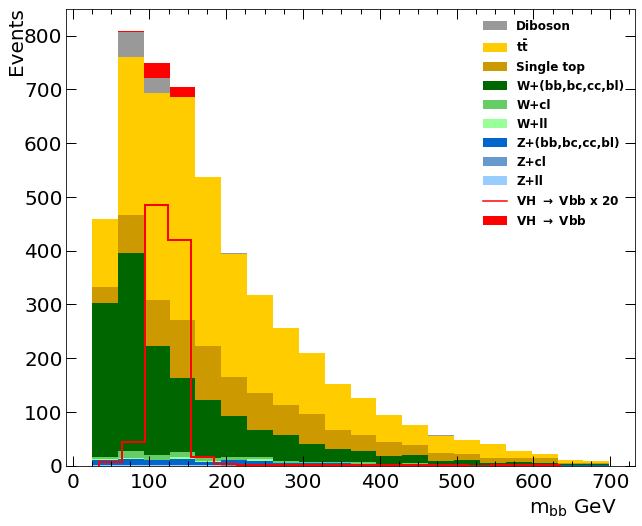

Sensitivity achieved before cuts  1.4315010699504847
Sensitivity achieved after first cut  1.5840108518283766
Sensitivity achieved after first cut  1.5830630141552924


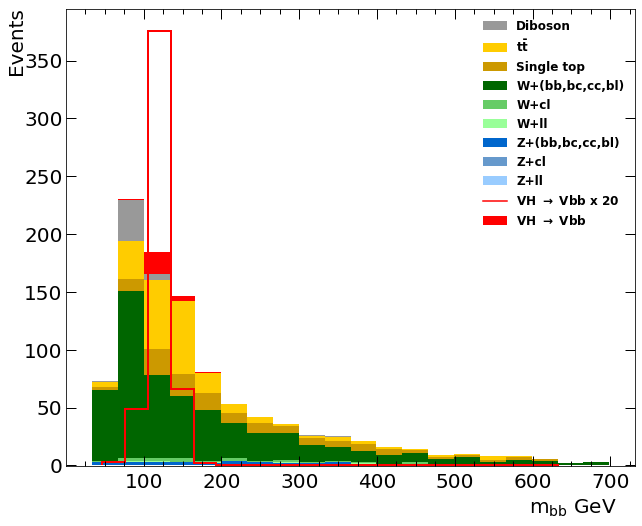

Sensitivity achieved after cuts  1.5830630141552924


In [24]:
# Reload data
df = pd.read_csv('../data-v1/VHbb_data_2jet.csv')

# The code below plots the mBB distribution after the cut is applied
plot_variable(df_original,'mBB')
print("Sensitivity achieved before cuts ",sensitivity_cut_based(df_original))


# Apply first cut
df = df.loc[df["Mtop"] / 1e3 > 250] # divide by 1e3 to convert from MeV to GeV
print("Sensitivity achieved after first cut ",sensitivity_cut_based(df))


# Apply second cut
df = df.loc[df["dRBB"] > 0.5] # divide by 1e3 to convert from MeV to GeV
print("Sensitivity achieved after second cut ",sensitivity_cut_based(df))

plot_variable(df,'mBB')

print("Sensitivity achieved after cuts ",sensitivity_cut_based(df))

### Why does applying 2 cuts sometimes decrease sensitivity

You may have noticed that some cuts work when we apply them to a single variable, but once we cut two variables at once we sometimes decrease the sensitivity. The reason for this is the non-linear relationships 

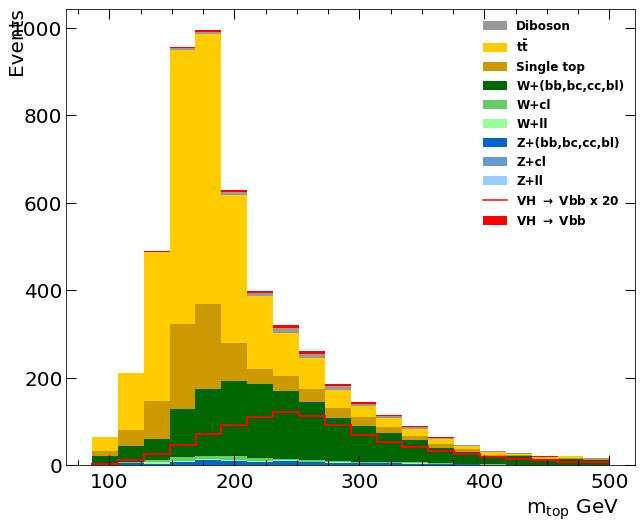

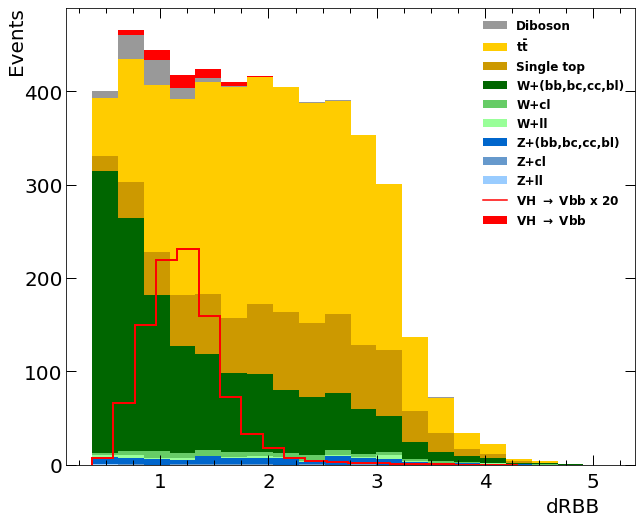

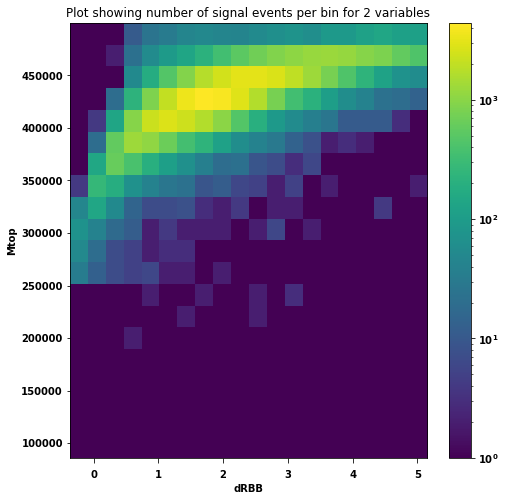

In [73]:
import matplotlib
def Plot2DSignalDensity(df, var1, var2):
    '''
    Plots a 2d image that shows the number of events
    within a given bin are signal (Higgs) events.
    This allows for 2 variables to be plotted and compared simultaneously 
    
    Parameters:
        df - The pandas dataframe containing our data
        var1 - The variable to plot along the x axis
        var2 - The variable to plot along the y axis
    
    '''
    
    bins = 20
    
    min_1 = np.amin(df[var1])
    max_1 = np.amax(df[var1])
    d1 = (max_1 - min_1)/bins
    
    min_2 = np.amin(df[var2])
    max_2 = np.amax(df[var2])
    d2 = (max_2 - min_2)/bins
    
    ratios = np.zeros((bins,bins))
    
    for x in range(0, bins):
        for y in range(0, bins):
            bxl = min_1 + x * d1
            bxu = min_1 + (x+1) * d1
            
            byl = min_2 + y * d2
            byu = min_2 + (y+1) * d2
            
            sel = df.loc[(df[var1] > bxl) & (df[var1] < bxu) &
                         (df[var2] > byl) & (df[var2] < byu)]
            
            
            ratios[x,y] = len(sel.loc[sel['Class'] == 1]) # / len(sel)
            if(ratios[x,y] < 1):
                ratios[x,y] = 1
    
    plt.figure(figsize=(8,8))
    extent=[-min_1, max_1, min_2, max_2]
    plt.imshow(ratios, extent=extent, aspect="auto", norm=mpl.colors.LogNorm())
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.colorbar()
    plt.title("Plot showing number of signal events per bin for 2 variables")
    

plot_variable(df_original,'Mtop')
plot_variable(df_original,'dRBB')

Plot2DSignalDensity(df_original, 'dRBB', 'Mtop')


We see that when we look in 2 dimensions, a set of simple cuts is harder to choose. Ideally, we want to cut a curve in this plot, but this would be hard to do.
Tomorrow, we shall let a neural network do this task. The complexity of a neural network means higher-order cuts can easily be applied to maximise the sensitivity.

### Summary

In this tutorial you developed a cut-based analysis on Monte Carlo generated ATLAS data to search for the Higgs Boson's decay to a pair of _b_-quarks. This is a tried and tested approach that is much loved by physicists as one can theoretically motivate the cuts to create a signal region. But can we improve on this? In the next tutorial we will be using Machine Learning to push the boundaries of our analysis and try to obtain sensitivity gains. 